In [1]:
import pandas as pd
import numpy as np
from recommender_metrics.plots import LongTailPlot, CoveragePlot, MarkPlot
from recommender_metrics.metrics import mark, coverage, personalization, intra_list_similarity
import matplotlib.pyplot as plt

# MovieLense Dataset
Using the MovieLens 20M Dataset dataset for examples. You can download this data here: https://grouplens.org/datasets/movielens/20m/

In [2]:
ratings = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/ratings.csv')
ratings = ratings.query('rating >=3')
ratings.reset_index(drop=True, inplace=True)

In [3]:
#only consider ratings from users who have rated over 1000 movies
users = ratings.userId.value_counts()
users = users[users>1000].index.tolist()

In [4]:
ratings = ratings.query('userId in @users')
print ratings.shape
ratings.head(3)

(1317902, 4)


,userId,movieId,rating,timestamp
15918,156,1,5.0,1037739266
15919,156,2,5.0,1040937649
15920,156,4,3.0,1038801803


In [5]:
# get movie features

rated_movies = ratings.movieId.tolist()
movies = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/movies.csv')
movies = movies.query('movieId in @rated_movies')
movies.set_index("movieId", inplace=True, drop=True)

movies = movies.genres.str.split("|", expand=True)
movies.reset_index(inplace=True)
movies = pd.melt(movies, id_vars='movieId', value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
movies.set_index('movieId', inplace=True)

movies = pd.get_dummies(movies.value)
movies.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Long Tail Plot Example

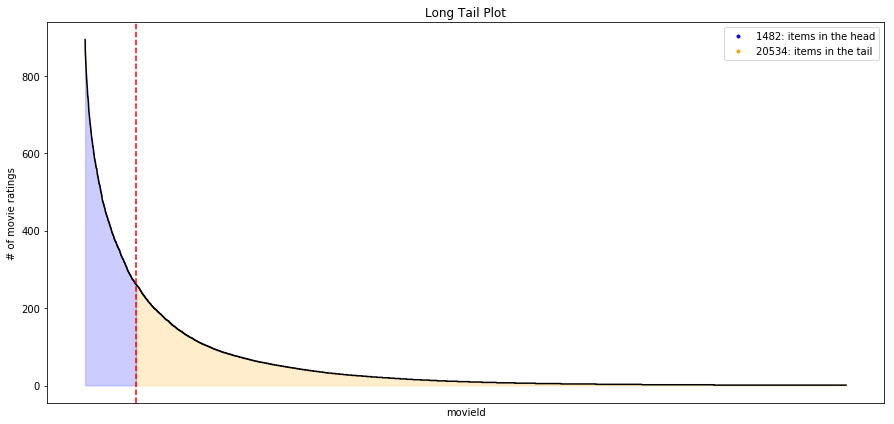

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))
    
LongTailPlot(df=ratings, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

# Simple Popularity Recommender
Creating a simple popularity recommender to demonstrate recommender metrics in action. The popularity recommender simply recommends the top 10 movies to every user.

## test/train split

In [7]:
# the test data contains 100 movies from each user that are rated greater than 3 stars
test_index = ratings.copy()
test_index = test_index.groupby('userId')
test_index = test_index.apply(lambda x: x.sample(min(100, len(x))))

test_index.drop(axis=1, columns="userId", inplace=True)
test_index.reset_index(inplace=True, drop=False)
test_index = test_index.level_1.values.tolist()

test_df = ratings.loc[test_index]
test = test_df.copy().groupby('userId')['movieId'].agg({'actual': (lambda x: list(set(x)))})
test.head()

/Users/clairelongo/Documents/Work/prof_dev/recommender_metrics/venv/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()


,actual
userId,
156,"[2565, 9, 3087, 4625, 2067, 1556, 2071, 537, 5..."
208,"[54272, 69122, 25771, 517, 3079, 1544, 55820, ..."
359,"[1, 33794, 6149, 1544, 41997, 6678, 24, 7173, ..."
394,"[6659, 44555, 2066, 3608, 7708, 34338, 8228, 2..."
572,"[54272, 2, 516, 1029, 257, 54281, 4632, 39449,..."


In [8]:
train_long = ratings[~ratings.index.isin(test_index)].dropna()
train_long.head()

,userId,movieId,rating,timestamp
15918,156,1,5.0,1037739266
15919,156,2,5.0,1040937649
15920,156,4,3.0,1038801803
15921,156,5,3.0,1040944583
15922,156,6,4.0,1037822117


## Popularity Recommendations

In [9]:
#make popularity recommendations for all members in the test data
popularity_recs = train_long.movieId.value_counts().head(10).index.tolist()

recs = []
for user in test.index.tolist():
    pop_predictions = popularity_recs
    recs.append(pop_predictions)
        
test['pop_predictions'] = recs
test.head()

,actual,pop_predictions
userId,,
156,"[2565, 9, 3087, 4625, 2067, 1556, 2071, 537, 5...","[1198, 1270, 593, 2571, 260, 296, 1240, 1196, ..."
208,"[54272, 69122, 25771, 517, 3079, 1544, 55820, ...","[1198, 1270, 593, 2571, 260, 296, 1240, 1196, ..."
359,"[1, 33794, 6149, 1544, 41997, 6678, 24, 7173, ...","[1198, 1270, 593, 2571, 260, 296, 1240, 1196, ..."
394,"[6659, 44555, 2066, 3608, 7708, 34338, 8228, 2...","[1198, 1270, 593, 2571, 260, 296, 1240, 1196, ..."
572,"[54272, 2, 516, 1029, 257, 54281, 4632, 39449,...","[1198, 1270, 593, 2571, 260, 296, 1240, 1196, ..."


In [10]:
actual = test.actual.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()

# Collaborative Filter

In [11]:
train_pivot = train_long.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
user_index = train_pivot.index.tolist()
movie_index = train_pivot.columns.tolist()
train_pivot.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,131168,131174,131176,131239,131243,131248,131250,131252,131254,131256
userId,,,,,,,,,,,,,,,,,,,,,
156,5.0,5.0,0.0,3.0,3.0,4.0,4.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
359,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

#svd
U, sigma, Vt = svds(train_pivot, k=100) # k is the number of factors
eigvals = sigma**2 / np.cumsum(sigma)[-1]
eigvals = eigvals[::-1]
sigma = np.diag(sigma)

#reconstruct ratings matrix
cf_model = np.dot(np.dot(U, sigma), Vt) 
cf_model = pd.DataFrame(cf_model, index=user_index, columns=movie_index)

In [13]:
cf_model.head()

,1,2,3,4,5,6,7,8,9,10,...,131168,131174,131176,131239,131243,131248,131250,131252,131254,131256
156,3.982770,4.753680,1.138879,2.400124,1.599260,3.031086,4.129993,1.017304,1.152341,3.707761,...,-0.032969,-0.063859,-0.082104,-0.001428,-0.001428,-0.001428,-0.001428,-0.001428,-0.001428,-0.001428
208,4.011288,0.187830,0.002901,0.630747,-0.104660,1.560753,0.156854,0.007570,0.307596,0.096694,...,-0.007711,0.018370,0.023619,-0.010993,-0.010993,-0.010993,-0.010993,-0.010993,-0.010993,-0.010993
359,3.074361,1.829040,0.032525,-0.211038,-0.209924,4.127409,0.794530,-0.050056,0.219132,1.793318,...,-0.006924,-0.023594,-0.030335,0.007380,0.007380,0.007380,0.007380,0.007380,0.007380,0.007380
394,3.138670,0.458998,0.447257,-0.183069,0.117592,1.428698,0.038063,-0.015315,0.096078,1.217831,...,-0.023610,-0.002710,-0.003484,0.003278,0.003278,0.003278,0.003278,0.003278,0.003278,0.003278
572,3.926069,1.578688,2.915546,-0.105552,1.620572,1.176980,0.236665,0.075367,0.058834,1.142673,...,0.000238,0.021823,0.028058,-0.005787,-0.005787,-0.005787,-0.005787,-0.005787,-0.005787,-0.005787


## Collaborative Filter Recommendations

In [14]:
def get_users_predictions(user_id, n, model, train_long):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    rated_items_from_train = train_long.query('userId == @user_id').movieId.tolist()
    recommended_items = recommended_items[~recommended_items.index.isin(rated_items_from_train)]
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [15]:
get_users_predictions(156, 10, cf_model, train_long)

[3702, 3686, 653, 110, 4351, 2028, 4018, 3361, 4681, 3708]

In [16]:
#make popularity recommendations for all members in the test data

recs = []
for user in user_index:
    cf_predictions = get_users_predictions(user, 10, cf_model, train_long)
    recs.append(cf_predictions)
        
test['cf_predictions'] = recs
test.head()

,actual,pop_predictions,cf_predictions
userId,,,
156,"[2565, 9, 3087, 4625, 2067, 1556, 2071, 537, 5...","[1198, 1270, 593, 2571, 260, 296, 1240, 1196, ...","[3702, 3686, 653, 110, 4351, 2028, 4018, 3361,..."
208,"[54272, 69122, 25771, 517, 3079, 1544, 55820, ...","[1198, 1270, 593, 2571, 260, 296, 1240, 1196, ...","[3481, 515, 2064, 1449, 39, 2303, 1198, 1307, ..."
359,"[1, 33794, 6149, 1544, 41997, 6678, 24, 7173, ...","[1198, 1270, 593, 2571, 260, 296, 1240, 1196, ...","[33794, 2762, 1214, 47610, 8783, 1193, 1127, 4..."
394,"[6659, 44555, 2066, 3608, 7708, 34338, 8228, 2...","[1198, 1270, 593, 2571, 260, 296, 1240, 1196, ...","[750, 111, 1204, 3683, 515, 3608, 6331, 954, 1..."
572,"[54272, 2, 516, 1029, 257, 54281, 4632, 39449,...","[1198, 1270, 593, 2571, 260, 296, 1240, 1196, ...","[49278, 7445, 5445, 3255, 44191, 318, 6879, 40..."


In [17]:
cf_predictions = test.cf_predictions.values.tolist()

# Recall

In [18]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([mark(actual, pop_predictions, k=K)])
pop_mark

[0.0007931404072883172,
 0.0011629153269024654,
 0.00146659521257592,
 0.0016648803143979993,
 0.00186638085030368,
 0.0020200071454090744,
 0.002176185372326851,
 0.002314181085081407,
 0.0024666164786743567,
 0.0025802284829616025]

In [19]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([mark(actual, cf_predictions, k=K)])
cf_mark

[0.007792068595927117,
 0.014646302250803857,
 0.02093426223651304,
 0.026451411218292243,
 0.031647552697391924,
 0.03644569489103251,
 0.04095342724442402,
 0.045589011381615877,
 0.049677376273839294,
 0.05372346416237092]

# Mark Plot

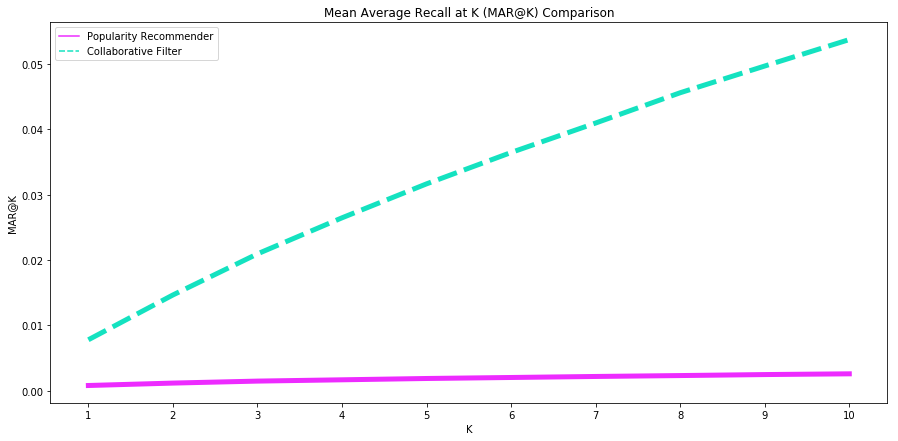

In [20]:
mark_scores = [pop_mark, cf_mark]
index = range(1,10+1)
names = ['Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
MarkPlot(mark_scores, model_names=names, k_range=index)

# Coverage

In [21]:
catalog = train_long.movieId.unique().tolist()
pop_coverage = coverage(pop_predictions, catalog)
cf_coverage = coverage(cf_predictions, catalog)

# Coverage Plot

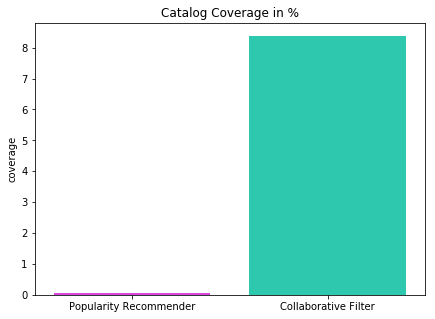

In [22]:
coverage_scores = [pop_coverage, cf_coverage]
model_names = ['Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(7, 5))
CoveragePlot(coverage_scores, model_names)

# Personalization

In [38]:
personalization(predicted=pop_predictions)

0.9999999999999999

In [39]:
personalization(predicted=cf_predictions)

0.013110598972349105

# Intra-list Similarity

In [36]:
intra_list_similarity(predicted=pop_predictions, feature_df=movies)

0.08888888888888888

In [37]:
intra_list_similarity(predicted=cf_predictions, feature_df=movies)

0.14478980588305349